<a href="https://colab.research.google.com/github/gcunhase/ML-Notebook/blob/master/ml_question_smartfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About
* **Goal**: "You need to create a new image from an existing one, but need to embed it naturally to a new (given) background in a certain place with neural networks. How would you approach this task?"
* **Proposed method**: Proposed approach: image/object segmentation with FCN ResNet-101, convert the generated output to a mask and then just add the new background. [[Torchvision models](https://pytorch.org/docs/stable/torchvision/models.html), [DenseNet Colab](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_densenet.ipynb)]
* **Task**: object segmentation
* **Dataset**: [COCO dataset](https://cocodataset.org/#home) [[COCO for image segmentation](https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047)]


## Requirements
PyTorch

In [ ]:
import os
import os.path
import numpy as np

# Torch
import torch

# Download annotations
import urllib
import zipfile

# Load data
import torch.utils.data as data
from PIL import Image, ImageMath, ImageDraw
from torchvision import transforms
import torchvision
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

%matplotlib inline
from matplotlib import pyplot as plt

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-2clzv09_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-2clzv09_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266465 sha256=1db29918f199b84e984d9f056161665eee273b8b2773c15bd86288b62c37ccaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-vzlsdgdq/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


## 0. Settings

In [ ]:
# CUDA for PyTorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parameters
def ensure_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

params = {"data_dir": 'data/',
          "zip_filename": "annotations_trainval2017.zip",
          "new_background_filename": 'data/new_background.jpg',
          "do_use_pretrained_weights": True,
          }

ensure_dir(params['data_dir'])

## 1. Data

### 1.1. Download annotations
[Download json annotations](http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip)

In [ ]:
url, filename = ("http://images.cocodataset.org/annotations/annotations_trainval2017.zip", params['zip_filename'])
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

url, filename = ("http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip", "stuff_annotations_trainval2017.zip")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

url, filename = ("http://images.cocodataset.org/zips/val2017.zip", "val2017.zip")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

if not params["do_use_pretrained_weights"]:
  url, filename = ("http://images.cocodataset.org/zips/train2017.zip", "train2017.zip")
  try: urllib.URLopener().retrieve(url, filename)
  except: urllib.request.urlretrieve(url, filename)

Unzip the annotations and validation data into the `./data` directory.

In [ ]:
# Unzip
with zipfile.ZipFile(params['zip_filename'], 'r') as zip_ref:
    zip_ref.extractall(params['data_dir'])

with zipfile.ZipFile("stuff_annotations_trainval2017.zip", 'r') as zip_ref:
    zip_ref.extractall(params['data_dir'])

with zipfile.ZipFile(params['data_dir']+"annotations/stuff_val2017_pixelmaps.zip", 'r') as zip_ref:
    zip_ref.extractall(params['data_dir']+"annotations/")

with zipfile.ZipFile("val2017.zip", 'r') as zip_ref:
    zip_ref.extractall(params['data_dir'])

if not params["do_use_pretrained_weights"]:
  with zipfile.ZipFile(params['data_dir']+"annotations/stuff_train2017_pixelmaps.zip", 'r') as zip_ref:
      zip_ref.extractall(params['data_dir']+"annotations/")

  with zipfile.ZipFile("train2017.zip", 'r') as zip_ref:
      zip_ref.extractall(params['data_dir'])
  !rm train2017.zip

# Remove .zip files
!rm stuff_annotations_trainval2017.zip annotations_trainval2017.zip val2017.zip

## 1.2. Data handler
Returns the input image and 2 target images (semantic segmentation and black and white segmentation image).

In [ ]:
class CocoSegmentation(data.Dataset):
    """Based on the `CocoDetection` function at <https://pytorch.org/docs/0.4.0/_modules/torchvision/datasets/coco.html>`.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
    """

    def __init__(self, root, annFile, target_root, transform=None, 
                 target_transform=None, target_bw_transform=None):
        from pycocotools.coco import COCO
        self.root = root
        self.target_root = target_root
        self.coco = COCO(annFile)
        # Print COCO categories
        cats = self.coco.loadCats(self.coco.getCatIds())
        nms=[cat['name'] for cat in cats]
        print('COCO categories: \n{}\n'.format(' '.join(nms)))
        print('Number of COCO categories: {}\n'.format(len(nms)))
        nms = set([cat['supercategory'] for cat in cats])
        print('COCO supercategories: \n{}'.format(' '.join(nms)))
        # Option 1: use all images, regardless of class
        self.ids = list(self.coco.imgs.keys())
        # Option 2: use just images with 'person' (person class is not included)
        #   https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
        # Choose only photos in a certain category
        #catIds = self.coco.getCatIds(catNms=['cardboard']) # cardboard, clothes
        #self.ids = self.coco.getImgIds(catIds=catIds)
        #print(self.ids)
        self.transform = transform
        self.target_transform = target_transform
        self.target_bw_transform = target_bw_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target, taget_bw).
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        #target_class = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        target = Image.open(os.path.join(self.target_root, path.replace('jpg', 'png'))).convert('RGB')
        # Make target image black and white according to the yellow
        target_bw = target.copy()
        for i in range(target_bw.size[0]):
            for j in range(target_bw.size[1]):
                if target_bw.getpixel((i,j)) == (255, 214, 0):
                    # Change to white if yellow
                    target_bw.putpixel((i, j), (255, 255, 255))
                else:
                    # Change to black if not yellow
                    target_bw.putpixel((i, j), (0, 0, 0))
        # Transform target images
        if self.target_transform is not None:
            target = self.target_transform(target)
        if self.target_bw_transform is not None:
            target_bw = self.target_bw_transform(target_bw)

        return img, target, target_bw


    def __len__(self):
        return len(self.ids)
    
    def __coco__(self):
      return self.coco

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

# Delete background from image given a B&W mask
# out_pil = Image.composite(input_image, background_image, mask)
def get_masked_image(img, mask, background=None):
    tensor2pil = transforms.ToPILImage()
    #img = tensor2pil(img)#.convert("RGB")
    img = img.cpu().detach().numpy()
    mask = tensor2pil(mask).convert("RGB")
    print(mask.size)
    for i in range(mask.size[0]):
      for j in range(mask.size[1]):
        if (0, 0, 0) <= mask.getpixel((j,i)) <= (150,150,150): # column, row
          # Delete pixels from the main image
          #img.putpixel((i, j), (255, 255, 255))
          if background is None:
            img[:,i,j] = [255,255,255] # row, column
          else:
            img[:,i,j] = background[:,i,j]
    return img

## 1.3. Load data
The DenseNet pre-trained models from torchvision expect the input images to be: 3-channel RGB images (3, 224+, 224+) and normalized with `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
target_bw_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
data_tensor = CocoSegmentation(params['data_dir']+'val2017/', 
                               annFile=params['data_dir']+'annotations/stuff_val2017.json',
                               target_root=params['data_dir']+'annotations/stuff_val2017_pixelmaps/', 
                               transform=transform,
                               target_transform=transform,
                               target_bw_transform=target_bw_transform)
data_batch = data.DataLoader(data_tensor, batch_size=16, shuffle=False, num_workers=6)
if not params["do_use_pretrained_weights"]:
  train_data_tensor = CocoSegmentation(params['data_dir']+'train2017/', 
                               annFile=params['data_dir']+'annotations/stuff_train2017.json',
                               target_root=params['data_dir']+'annotations/stuff_train2017_pixelmaps/', 
                               transform=transform,
                               target_transform=transform,
                               target_bw_transform=target_bw_transform)
  train_data_batch = data.DataLoader(train_data_tensor, batch_size=16, shuffle=False, num_workers=6)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
COCO categories: 
banner blanket branch bridge building-other bush cabinet cage cardboard carpet ceiling-other ceiling-tile cloth clothes clouds counter cupboard curtain desk-stuff dirt door-stuff fence floor-marble floor-other floor-stone floor-tile floor-wood flower fog food-other fruit furniture-other grass gravel ground-other hill house leaves light mat metal mirror-stuff moss mountain mud napkin net paper pavement pillow plant-other plastic platform playingfield railing railroad river road rock roof rug salad sand sea shelf sky-other skyscraper snow solid-other stairs stone straw structural-other table tent textile-other towel tree vegetable wall-brick wall-concrete wall-other wall-panel wall-stone wall-tile wall-wood water-other waterdrops window-blind window-other wood other

Number of COCO categories: 92

COCO supercategories: 
furniture-stuff water food-stuff window solid wall plant raw-material

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f8c0c856240>,
 (0.0, 1.0, 0.0, 1.0),
 Text(0.5, 1.0, 'Object w/o background'))

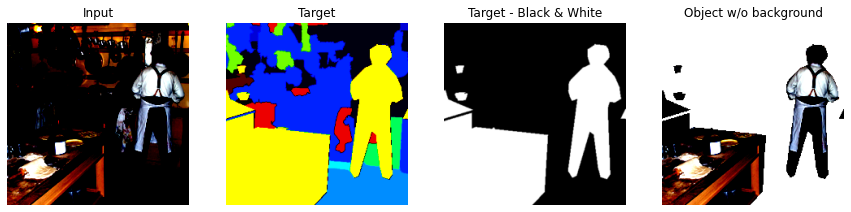

In [ ]:
# Example 1
img, target, target_bw = data_tensor[0]
plt.subplots(1, 4, figsize=(15,15))
plt.subplot(1, 4, 1), plt.axis('off'), plt.imshow(img.permute([1,2,0])), plt.title('Input')
plt.subplot(1, 4, 2), plt.axis('off'),  plt.imshow(target.permute([1,2,0])), plt.title('Target')
plt.subplot(1, 4, 3), plt.axis('off'),  plt.imshow(target_bw.permute([1,2,0])), plt.title('Target - Black & White')
masked_img = get_masked_image(img, target_bw)
plt.subplot(1, 4, 4), plt.axis('off'),  plt.imshow(masked_img.transpose([1,2,0])), plt.title('Object w/o background')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.axes._subplots.AxesSubplot at 0x7f8c4ae87198>,
 (0.0, 1.0, 0.0, 1.0),
 Text(0.5, 1.0, 'Object w/o background'))

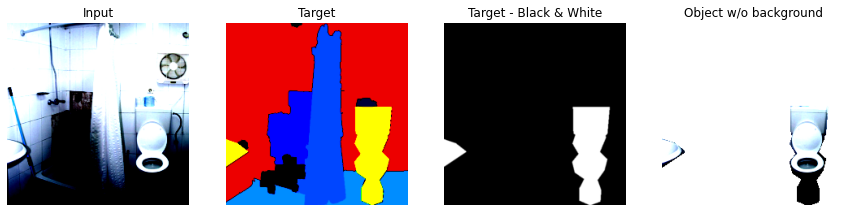

In [ ]:
# Example 2
img, target, target_bw = data_tensor[5]
plt.subplots(1, 4, figsize=(15,15))
plt.subplot(1, 4, 1), plt.axis('off'), plt.imshow(img.permute([1,2,0])), plt.title('Input')
plt.subplot(1, 4, 2), plt.axis('off'),  plt.imshow(target.permute([1,2,0])), plt.title('Target')
plt.subplot(1, 4, 3), plt.axis('off'),  plt.imshow(target_bw.permute([1,2,0])), plt.title('Target - Black & White')
masked_img = get_masked_image(img, target_bw)
plt.subplot(1, 4, 4), plt.axis('off'),  plt.imshow(masked_img.transpose([1,2,0])), plt.title('Object w/o background')

## 1.4 Load pre-trained model
[FCN ResNet101](https://pytorch.org/docs/stable/torchvision/models.html#semantic-segmentation)

In [ ]:
if params["do_use_pretrained_weights"]:
  # Trained on COCO train2017, outputs 21 classes (same as PASCAL VOC2012)
  model = torchvision.models.segmentation.fcn_resnet101(pretrained=True, progress=True)
  model.eval()
else:
  # Train from scratch on COCO train2017
  # Note: train data is too big to train from scratch on Colab
  print("TODO: TEST")
  model = torchvision.models.segmentation.fcn_resnet101(pretrained=False, progress=True)
  model.train()
  model.to(device)
  
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  loss_function = torch.nn.KLDivLoss()
  for input, target, target_bw, target_class in train_data_batch:
      optimizer.zero_grad()

      input = input.to(device)
      target = target.to(device)
      output = model(input)

      loss = loss_function(output, target)
      loss.backward()
      optimizer.step()

In [ ]:
model.to(device)

with torch.no_grad():
    for input, target, target_bw in data_batch:
        input = input.to(device)
        output = model(input)
        break;
# output.keys() # ['out', 'aux']
print(output['out'].size())

torch.Size([16, 21, 224, 224])


In [ ]:
new_background_image = input[1].cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224)
(224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.axes._subplots.AxesSubplot at 0x7f8be7403c18>,
 (-0.5, 223.5, 223.5, -0.5),
 Text(0.5, 1.0, 'Object + New background'))

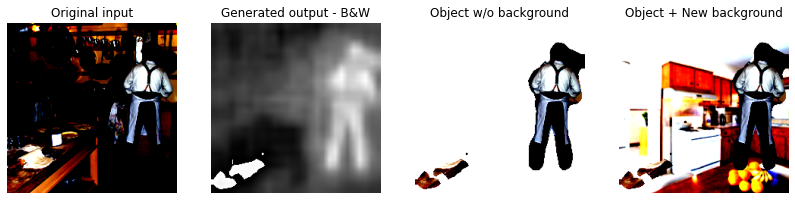

In [ ]:
idx = 0
# INPUT
input_image = input[idx].cpu().detach()
#input_image = input_image / input_image.max()
input_image = input_image.numpy()
# Original Output
t = target[idx]
# Generated OUTPUT
out = output['out'][idx].cpu().detach().numpy()
#out_class = torch.tensor(out[15, :, :]) # person, max 20
out_class = out[15, :, :] # person, max 20
out_class_tensor = torch.tensor(out_class)
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()
out_pil = tensor2pil(out_class_tensor).convert("RGB")
out_class_tensor_bw = torch.tensor(out_class)#.astype(np.uint8))
# Normalize between 0 and 1
out_class_tensor_bw = out_class_tensor_bw / out_class_tensor_bw.max()
out_class_tensor_bw = tensor2pil(out_class_tensor_bw).convert("RGB")
out_pil = get_masked_image(input[idx], pil2tensor(out_class_tensor_bw))
out_pil_with_background = get_masked_image(input[idx], pil2tensor(out_class_tensor_bw), background=new_background_image)
# PLOTS
plt.subplots(1, 4, figsize=(14,14))
plt.subplot(1,4,1), plt.imshow(input_image.transpose([1,2,0])), plt.axis('off'), plt.title('Original input')
#plt.subplot(1,5,2), plt.imshow(t.permute([1,2,0])), plt.axis('off'), plt.title('Original output')
#plt.subplot(1,5,3), plt.imshow(out_class_tensor), plt.axis('off'), plt.title('Generated output')
plt.subplot(1,4,2), plt.imshow(out_class_tensor_bw), plt.axis('off'), plt.title('Generated output - B&W')
plt.subplot(1,4,3), plt.imshow(out_pil.transpose([1,2,0])), plt.axis('off'), plt.title('Object w/o background')
plt.subplot(1,4,4), plt.imshow(out_pil_with_background.transpose([1,2,0])), plt.axis('off'), plt.title('Object + New background')

(224, 224)
(224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.axes._subplots.AxesSubplot at 0x7f8be72598d0>,
 (-0.5, 223.5, 223.5, -0.5),
 Text(0.5, 1.0, 'Object + New background'))

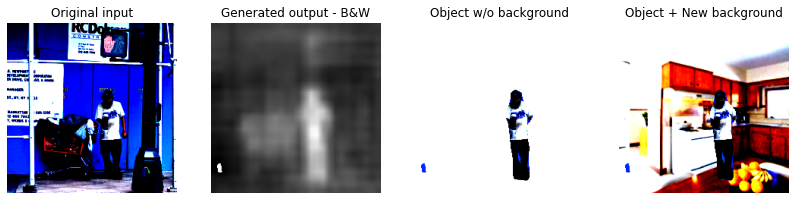

In [ ]:
idx = 2
# INPUT
input_image = input[idx].cpu().detach()
#input_image = input_image / input_image.max()
input_image = input_image.numpy()
# Original Output
t = target[idx]
# Generated OUTPUT
out = output['out'][idx].cpu().detach().numpy()
out_class = out[15, :, :] # person, max 20
out_class_tensor = torch.tensor(out_class)
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()
out_pil = tensor2pil(out_class_tensor).convert("RGB")
out_class_tensor_bw = torch.tensor(out_class)#.astype(np.uint8))
# Normalize between 0 and 1
out_class_tensor_bw = out_class_tensor_bw / out_class_tensor_bw.max()
out_class_tensor_bw = tensor2pil(out_class_tensor_bw).convert("RGB")
out_pil = get_masked_image(input[idx], pil2tensor(out_class_tensor_bw))
out_pil_with_background = get_masked_image(input[idx], pil2tensor(out_class_tensor_bw), background=new_background_image)
# PLOTS
plt.subplots(1, 4, figsize=(14,14))
plt.subplot(1,4,1), plt.imshow(input_image.transpose([1,2,0])), plt.axis('off'), plt.title('Original input')
plt.subplot(1,4,2), plt.imshow(out_class_tensor_bw), plt.axis('off'), plt.title('Generated output - B&W')
plt.subplot(1,4,3), plt.imshow(out_pil.transpose([1,2,0])), plt.axis('off'), plt.title('Object w/o background')
plt.subplot(1,4,4), plt.imshow(out_pil_with_background.transpose([1,2,0])), plt.axis('off'), plt.title('Object + New background')

### Notes
* [PIL Image with Python](https://www.cs.virginia.edu/~vicente/recognition/notebooks/image_processing_lab.html)
* Datasets: [COCO dataset](https://cocodataset.org/#home) [[COCO for image segmentation](https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047)], [PennFudan dataset](https://www.cis.upenn.edu/~jshi/ped_html/), [PASCAL VOC2012 dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/)

In [ ]:
# PASCAL VOC2012
# Classes: ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
#           'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']